# Small-Cap Stock Price Movement Prediction

#### Author: Jake Oddi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from td.client import TDClient
import requests
import json
import time
from config import ameritrade_credentials 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
np.random.seed(seed = 1)

## Overview

This project applies classification methods to the daily price data of stocks with market capitalizations between \\$75M and \\$1B from the past three years to predict intraday price movements. Instances where the closing price exceeds the opening price are considered positive cases, and instances where the opposite is true are considered negative.

## Business Problem

Quantitative analysis of stocks has become increasingly popular over the past decades, to the point where it is ubiqiutous among insitutional investors. Among individual investors, however, it is less widespread. This is due to a general lack of the technical skills required to perform such analysis. I ran into this issue myself when constructing my portfolio. I predict an easy-to-use, open-source model would serve to benefit this population. 

My analysis focuses on small-cap companies because they typically see lower trading volumes, and therefore have more inefficiencies that can be exploited. Conversely, this makes trades harder to execute at desirable prices. 

Predictions of price-movement-direction are nowhere near perfect, and should only be used in conjunction with additional information.

## Data Understanding

### Data Acquisition

To decide which companies to model, I employed a stock screener from [TD Ameritrade](https://research.tdameritrade.com/grid/public/screener/stocks/overview.asp) to select stocks with market caps within my desired range. This yielded 8027 results. I filtered this down to 3055 results by removing companies worth less than \\$75M, as many companies below that threshold had such low trading volumnes that they were not conducive to modeling. For the sake of ease-of-use and proof-of-concept, I filtered this down further by randomly sampling 500. I then gathered daily price data from the past three years using [TD Ameritrade's Price History API](https://developer.tdameritrade.com/price-history/apis). Of these 500, the API failed for 157, leaving 343. Of the remaining, I selected only those with 755 days of data to use in my analysis, leaving me with 160 stocks. 

In [3]:
# Read in the screener
screen = pd.read_csv('ameritrade_stock_screener.csv', header = 0)

# Take a first look
screen.head()

,Symbol,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta
0,AAAIF,ALTERNATIVE INVESTMENT TRUST UNITS,2.856715e+07,NaN,NaN,--,+0.2
1,AACG,ATA Creativity Global(ADR),3.713346e+07,Consumer Discretionary,Diversified Consumer Services,--,+1.7
2,AACH,AAC Holdings Inc,4.025300e+05,Health Care,Health Care Providers & Services,--,+2.7
3,AACQ,Artius Acquisition Inc,9.341573e+08,NaN,NaN,--,--
4,AACS,"American Commerce Solutions, Inc.",6.946900e+05,Industrials,Road & Rail,--,-1.0


#### Screener Cleaning

In [4]:
# Rename screener columns
screen.columns = ['ticker', 'company', 'market_cap', 'sector', 'industry', 'dividend_yield', 'beta']

# Screening only for companies worth > $75M
screen = screen[screen['market_cap'] >= 75000000]

#### Selection

In [5]:
# Instantiate a list of 500 random integers for selection of df indices from the screener
rand_list = np.random.randint(0, screen.shape[0], 500)

# Filter the screener using the list of random indices
filtered_screen = screen.iloc[rand_list]

# Create a list of the tickers of all stocks selected by the filter
ticker_list = filtered_screen['ticker'].values

#### API Call - Configuration

In [6]:
# Import personal client ID
client_id = ameritrade_credentials.consumer_key

# Set payload params
period = '3'
period_type = 'year'
frequency = '1'
frequency_type = 'daily'
start_date = '1512172799'
end_date = '1606867199'

# Define payload
payload = {'apikey': client_id,
           'periodType': period_type,
           'frequencyType': frequency_type,
           'frequency': frequency,
           'period': period,
#            'endDate': end_date,
#            'startDate': start_date,
           'needExtendedHoursData': 'false'
          }

#### API Call

In [15]:
def get_data_from_ameritrade(ticker_list, payload):
    """
    Takes in list of tickers and payload and returns complete dataframe with all 
    tickers and prices.
    
    ticker_list -- array of strings containing n number of tickers
    payload -- dictionary containing parameters for API call
    
    """
    df_list = []
    fail_cache = []
    payload = payload
    for ticker in ticker_list:
        # Define endpoint
        endpoint = r'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(ticker)
        
        try:
            # Make Request
            content = requests.get(url = endpoint, params = payload)

            # Convert to dataframe
            data = content.json()
            data = pd.DataFrame(data = data['candles'])
            data['ticker'] = ticker

            # Append to list of dataframes
            df_list.append(data)
            
        except:
            # Append problematic ticker to list of failed tickers
            fail_cache.append(ticker)
            continue
    
    return df_list, fail_cache

In [16]:
# A list of dfs is instantiated, where each stock's data is stored in a dataframe
df_list, fail_cache = get_data_from_ameritrade(ticker_list, payload)

In [17]:
print('Length of df_list:', len(df_list))
print('Length of fail_cache', len(fail_cache))

Length of df_list: 321
Length of fail_cache 179


### Understanding

The API returned a dataframe with the following columns built in for each stock: opening price, daily high, daily low, closing price, datetime, volume, and ticker.

In [18]:
df_list[0].head()

,open,high,low,close,volume,datetime,ticker
0,9.9209,10.20,9.9209,10.0600,14008,1606456800000,FMAC
1,10.0600,10.11,9.9308,10.0100,8941,1606716000000,FMAC
2,10.5000,10.50,10.0100,10.1185,11327,1606802400000,FMAC
3,10.1500,10.27,9.9598,10.1250,25048,1606888800000,FMAC
4,10.1600,10.16,10.0100,10.0100,6529,1606975200000,FMAC


#### Final Filtering

In [19]:
df_list = list(filter(lambda x: x.shape[0] >= 755, df_list))

In [20]:
len(df_list)

160

## Cleaning

In [21]:
# Date Cleaning
def clean_dates(df_list):
    for df in df_list:
        # Convert from unix to year month day format
        df['datetime'] = pd.to_datetime(df['datetime'], unit = 'ms')

        # Set datetime as index
        df.set_index(df['datetime'], inplace = True)

        # Drop original datetime column
        df.drop(columns = 'datetime', inplace = True)
        
    return df_list

In [22]:
clean_dates(df_list)

[                      open     high      low  close  volume ticker
 datetime                                                          
 2017-12-18 06:00:00  19.45  19.8000  19.2000  19.30  156552   FRGI
 2017-12-19 06:00:00  19.25  19.5500  19.2000  19.35  126489   FRGI
 2017-12-20 06:00:00  19.50  19.6000  18.9500  19.05  149596   FRGI
 2017-12-21 06:00:00  19.15  19.4000  18.9000  19.30  207587   FRGI
 2017-12-22 06:00:00  19.35  19.4000  19.0250  19.25  254137   FRGI
 ...                    ...      ...      ...    ...     ...    ...
 2020-12-10 06:00:00  12.84  12.8774  12.3300  12.64  123167   FRGI
 2020-12-11 06:00:00  12.48  12.7600  12.3100  12.42   97892   FRGI
 2020-12-14 06:00:00  12.43  12.6350  11.9575  12.33   82460   FRGI
 2020-12-15 06:00:00  12.49  12.9600  12.3000  12.62   90697   FRGI
 2020-12-16 06:00:00  12.67  12.8500  12.4400  12.52  116272   FRGI
 
 [755 rows x 6 columns],
                       open     high      low  close  volume ticker
 datetime            

## Feature Engineering

## Modleing and Results

## Conclusion and Next Steps

### Inspection

<AxesSubplot:ylabel='Frequency'>

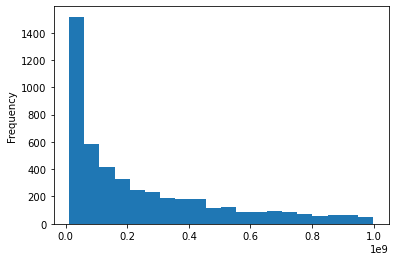

In [30]:
screen['market_cap'].plot(kind = 'hist', bins = 20)

In [21]:
len(df_list)

343

In [123]:
len_list = []
for df in df_list:
    len_list.append(df.shape[0])
    

In [124]:
len_list

[755,
 755,
 755,
 276,
 481,
 755,
 120,
 138,
 755,
 357,
 755,
 755,
 755,
 755,
 755,
 305,
 755,
 142,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 754,
 755,
 622,
 642,
 755,
 755,
 674,
 755,
 467,
 755,
 755,
 754,
 755,
 114,
 341,
 755,
 325,
 642,
 755,
 755,
 755,
 755,
 755,
 755,
 249,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 621,
 755,
 377,
 755,
 539,
 755,
 755,
 755,
 115,
 755,
 755,
 755,
 607,
 687,
 755,
 755,
 754,
 325,
 755,
 755,
 755,
 555,
 755,
 743,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 150,
 755,
 755,
 274,
 755,
 755,
 350,
 755,
 317,
 755,
 755,
 755,
 755,
 755,
 755,
 670,
 755,
 153,
 755,
 643,
 755,
 755,
 721,
 508,
 356,
 630,
 220,
 730,
 755,
 755,
 487,
 755,
 755,
 754,
 755,
 558,
 755,
 529,
 755,
 755,
 755,
 755,
 202,
 335,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 647,
 747,
 755,
 755,
 755,
 755,
 753,
 562,
 755,
 755,
 755,
 755,
 755,
 451,
 755,
 755,
 755,
 305,
 308,
 755,
 126

In [208]:
len(list(filter(lambda x: x.shape[0] >= 755, df_list)))

181

In [207]:
len(df_list)

282

<AxesSubplot:ylabel='Frequency'>

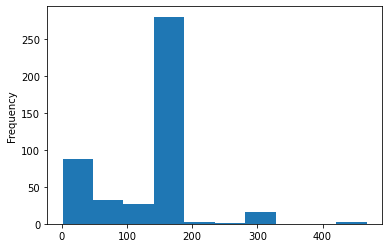

In [54]:
# Hist showing distribution of entry frequency in data

df['ticker'].value_counts().plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

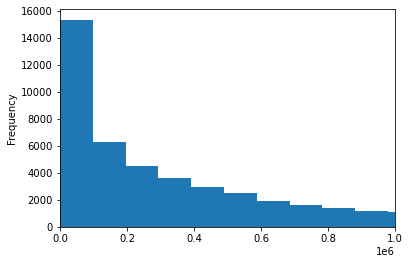

In [68]:
df['volume'].plot(kind = 'hist', xlim = (0,1000000), bins = 10000)

In [69]:
df['volume'].mean()

2013695.1376984685

## Feature Engineering

In [23]:
def create_moving_avs(df_list):
    """
    Takes in list of dfs, creates three different moving average 
    features - 10, 50, and 200 days.
    
    df_list -- list of dfs
    """
    for df in df_list:
        df['10_day_ma'] = df['close'].ewm(span = 10).mean()
        df['50_day_ma'] = df['close'].ewm(span = 50).mean()
        df['200_day_ma'] = df['close'].ewm(span = 200).mean()
     
    return df_list

In [ ]:
df_list = create_moving_avs(df_list)

In [24]:
def create_intra_clf_target(df_list):
    """
    Takes in list of dfs and creates target variable for each depending
    on if the closing price for each day exceeds the opening price. If the
    closing price exceeds the opening price, target = 1.
    
    df_list -- list of dfs
    """
    for df in df_list:
        df['intra_clf_target'] = 0
        for i in range(len(df)):
            
            if df['open'][i] < df['close'][i]:
                df['intra_clf_target'][i] = 1
            
            elif df['open'][i] > df['close'][i]:
                df['intra_clf_target'][i] = 0
    
            elif df['open'][i] == df['close'][i]:
                df['intra_clf_target'][i] = 2
    
    return df_list

<ipython-input-24-b975611ac847>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['intra_clf_target'][i] = 0
<ipython-input-24-b975611ac847>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['intra_clf_target'][i] = 1
<ipython-input-24-b975611ac847>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['intra_clf_target'][i] = 2


In [ ]:
df_list = create_intra_clf_target(df_list)

In [25]:
def create_pct_price_changes(df_list):
    """
    Takes in a list of dfs and creates price change (%) features with various
    intervals.
    Calculates % price changes relative to the day before observed date to 
    prediction using unknown data.
    
    df_list -- list of dfs
    """
    # Creating i_day_pct_change columns in each df
    for df in df_list:
        df['1_day_pct_change'] = 0
        df['2_day_pct_change'] = 0
        df['3_day_pct_change'] = 0
        df['4_day_pct_change'] = 0
   
        # Calculating ith day price change for each col
        for i in range(5, df.shape[0]):
            # Difference in closing prices between the previous day and the previous day
            diff = float(df['close'][i-1]) - float(df['close'][i-2])
            pct = (float(diff)/float(df['close'][i-2])) * 100
            df['1_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and two days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-3])
            pct = (float(diff)/float(df['close'][i-3])) * 100
            df['2_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and three days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-4])
            pct = (float(diff)/float(df['close'][i-4])) * 100
            df['3_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and four days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-5])
            pct = (float(diff)/float(df['close'][i-5])) * 100
            df['4_day_pct_change'][i] = pct
            

In [26]:
create_pct_price_changes(df_list)

<ipython-input-25-cd667ea08665>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['1_day_pct_change'][i] = pct
<ipython-input-25-cd667ea08665>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2_day_pct_change'][i] = pct
<ipython-input-25-cd667ea08665>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['3_day_pct_change'][i] = pct
<ipython-input-25-cd667ea08665>:37: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [27]:
df_list[0]

,open,high,low,close,volume,ticker,10_day_ma,50_day_ma,200_day_ma,intra_clf_target,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2017-12-18 06:00:00,19.45,19.8000,19.2000,19.30,156552,FRGI,19.300000,19.300000,19.300000,0,0,0,0,0
2017-12-19 06:00:00,19.25,19.5500,19.2000,19.35,126489,FRGI,19.327500,19.325500,19.325125,1,0,0,0,0
2017-12-20 06:00:00,19.50,19.6000,18.9500,19.05,149596,FRGI,19.215947,19.229969,19.232498,0,0,0,0,0
2017-12-21 06:00:00,19.15,19.4000,18.9000,19.30,207587,FRGI,19.243639,19.248541,19.249628,1,0,0,0,0
2017-12-22 06:00:00,19.35,19.4000,19.0250,19.25,254137,FRGI,19.245465,19.248857,19.249704,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-10 06:00:00,12.84,12.8774,12.3300,12.64,123167,FRGI,12.608804,11.093801,9.627179,0,0,1,0,0
2020-12-11 06:00:00,12.48,12.7600,12.3100,12.42,97892,FRGI,12.574476,11.145809,9.654983,0,-3,-3,-2,-3
2020-12-14 06:00:00,12.43,12.6350,11.9575,12.33,82460,FRGI,12.530026,11.192248,9.681615,0,-1,-4,-5,-3


## Modeling

In [39]:
def time_cross_validate(df, model, param_grid):
    """
    Takes in df, model, and param_grid, and returns cross validated scores and params.
    
    df -- dataframe
    model -- model to be used for cross validation
    param_grid -- dictionary to be used for GridSearch param_grid
    """
    # Designating predictor and target columns
    predictor_cols = ['10_day_ma', 
                      '50_day_ma', 
                      '200_day_ma', 
                      '1_day_pct_change',
                      '2_day_pct_change', 
                      '3_day_pct_change', 
                      '4_day_pct_change']
    target = 'intra_clf_target'
    
    # Creating dataframe with numerical index that can be split
    dataframe = df.reset_index()

    # Creating tuples of train, test indices to be passed into the cv parameter of GridSearchCV
    train_test_indices_1 = (list(range(455)), list(range(455, 530)))
    train_test_indices_2 = (list(range(530)), list(range(530, 605)))
    train_test_indices_3 = (list(range(605)), list(range(605, 680)))
    train_test_indices_4 = (list(range(680)), list(range(680, 755)))
    
    # Splitting the df into data and target values
    data, target = dataframe[predictor_cols], df[target]
    
    # Scaling the data
    scaler = StandardScaler()
    scaler.fit_transform(data)
    
    # Instantiating Gridsearch
    clf = GridSearchCV(estimator = model,
                       param_grid = param_grid,
                       cv = [train_test_indices_1,
                             train_test_indices_2,
                             train_test_indices_3,
                             train_test_indices_4
                       ],
                       n_jobs = -1,
                       scoring = 'f1_weighted',
                       verbose = False
    )
    
    # Fitting Gridsearch
    clf.fit(data, target)
    
    # Get results and store them in a dictionary
    best_score = clf.best_score_
    best_params = clf.best_params_
    best_params['best_score'] = best_score
    
    return best_params

In [29]:
rfc = RandomForestClassifier(random_state = 1)
knn = KNeighborsClassifier()

In [37]:
# Parameter grid for random forest cross validation
rfc_param_grid = {'n_estimators': [500, 750, 1000],
                  'class_weight': ['balanced'],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [3, 5, 7]
             }

# Parameter grid for knn cross validation
knn_param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                  'leaf_size': [15, 30, 40]
                 }

#### Random Forest

In [31]:
# Create a list of random forest best params and scores for first 10 dfs
rfc_gs_results = []

for df in df_list[:10]:
    result = time_cross_validate(df = df, model = rfc, param_grid = rfc_param_grid)
    rfc_gs_results.append(result)            

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   20.7s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   18.8s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   19.0s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   18.4s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   18.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   18.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   18.3s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   18.1s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   18.0s finished


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   18.6s finished


In [32]:
rfc_gs_results

[{'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 750,
  'best_score': 0.5372476826150502},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 1000,
  'best_score': 0.45255600701859716},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
  'n_estimators': 500,
  'best_score': 0.4235570630114009},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 3,
  'n_estimators': 500,
  'best_score': 0.41214265446641224},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
  'n_estimators': 1000,
  'best_score': 0.46301788199337024},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 3,
  'n_estimators': 500,
  'best_score': 0.4865972608170165},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
  'n_estimators': 1000,
  'best_score': 0.44688561506892566},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_d

In [35]:
# Calculating mean random forest F1 score for the first 10 stocks

rfc_gs_scores = []
for i in rfc_gs_results:
    rfc_gs_scores.append(i['best_score'])
np.mean(rfc_gs_scores)

0.4603205068467503

#### KNN

In [41]:
# Create a list of knn best params and scores for first 10 dfs
knn_gs_results = []

for df in df_list[:10]:
    result = time_cross_validate(df = df, model = knn, param_grid = knn_param_grid)
    knn_gs_results.append(result)            

In [42]:
knn_gs_results

[{'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 7,
  'best_score': 0.5561276934500141},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 4,
  'best_score': 0.47127110301113273},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 7,
  'best_score': 0.4826268020170537},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.4791097562301946},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 4,
  'best_score': 0.43731365556018653},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 5,
  'best_score': 0.48427436030720233},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.4645423782317034},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 6,
  'best_score': 0.44993615021796596},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.4916804165690549},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.4806952619214454}]

In [43]:
# Calculating mean KNN F1 score for the first 10 stocks

knn_gs_scores = []
for i in knn_gs_results:
    knn_gs_scores.append(i['best_score'])
np.mean(knn_gs_scores)

0.47975775775159535

In [45]:
def time_train_test_split(df, split_date):
    """
    Takes in a df and a date to split train and test sets
    on the split date and returns X_train, X_test, y_train, y_test.
    Built to be incorporated with time_cross_validate().
    
    df -- dataframe of prices
    split_date -- str formatted as 'YYYY-MM-DD'
    """
    # Create list of split components
    train_test_sets = [] # not being used
    
    # Create train and test sets
    train = df[:split_date]
    test = df[split_date:]
    
    # Create list of columns to use in prediction, as well as target variable
    predictor_cols = ['10_day_ma', 
                      '50_day_ma', 
                      '200_day_ma', 
                      '1_day_pct_change',
                      '2_day_pct_change', 
                      '3_day_pct_change', 
                      '4_day_pct_change']
    target = 'intra_clf_target'
    
    # Create train and test sets
    X_train, X_test = train[predictor_cols], test[predictor_cols]
    y_train, y_test = train[target], test[target]
    
    return X_train, X_test, y_train, y_test
    

In [51]:
def scale_and_plant_random_forests(X_train, X_test, y_train, y_test):
    """
    Takes in train and test sets, runs a Random Forest Classifier on each,
    then returns a tuple of y test and y predicted values to be
    passed through an f1_score
    
    X_train -- training prediction data
    X_test -- testing prediction data
    y_train -- training target data
    y_test -- testing target data
    """
    # Instantiate scaler
    scaler = StandardScaler()
    
    # Fit, transform on train set, only transform test set
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    
    # Instantiate Random Forest Classifier with gridsearched parameters
    rfc = RandomForestClassifier(random_state = 1,
                                 max_depth = 7,
                                 n_estimators = 1000,
                                 criterion = 'gini',
                                 class_weight = 'balanced'
                                )
    
    # Fit to the training data
    rfc.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = rfc.predict(X_test)
    
    return (y_test, y_pred)

In [61]:
def scale_and_knn(X_train, X_test, y_train, y_test):
    """
    Takes in train and test sets, runs a K Nearest Neighbors Classifier on each,
    then returns a tuple of y test and y predicted values to be
    passed through an f1_score.
    
    X_train -- training prediction data
    X_test -- testing prediction data
    y_train -- training target data
    y_test -- testing target data
    """
    # Instantiate scaler
    scaler = StandardScaler()
    
    # Fit, transform on train set, only transform test set
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    
    # Instantiate K Neighbors Classifier with gridsearched parameters
    knn = KNeighborsClassifier(algorithm = 'auto',
                               leaf_size = 15, 
                               n_neighbors = 3
                              )
    
    # Fit to the training data
    knn.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = knn.predict(X_test)
    
    return (y_test, y_pred)

In [48]:
X_train, X_test, y_train, y_test = time_train_test_split(df_list[0], '2020-05-20')

In [70]:
def compare_scores(df_list):
    """
    Takes in a list of dfs and returns a list of tuples to 
    compare the performance of two models based on their 
    respective F1 scores.
    
    df_list -- list of dfs
    """
    # Creating a list of tuples to compare model performance on each stock
    tuned_scores_comparison_list = []

    # Looping through the list of dfs
    for df in df_list:
        # Splitting train and test sets
        X_train, X_test, y_train, y_test = time_train_test_split(df, '2020-05-20')

        # Predicting with Random Forest
        (true, pred) = scale_and_plant_random_forests(X_train, X_test, y_train, y_test)

        # Evaluating Random Forest
        rfc_f1 = f1_score(true, pred, average = 'weighted')

        # Predicting with KNN
        (true, pred) = scale_and_knn(X_train, X_test, y_train, y_test)

        # Evaluating KNN
        knn_f1 = f1_score(true, pred, average = 'weighted')

        # Appending to list of tuples
        tuned_scores_comparison_list.append((rfc_f1, knn_f1))

    return tuned_scores_comparison_list

In [71]:
compare_scores(df_list[:10])

[(0.5336030964109783, 0.5374577820761773),
 (0.47007743189441675, 0.46603307254986537),
 (0.35472653511895713, 0.44690650453729885),
 (0.2542720437457279, 0.5107731981681561),
 (0.3989326370278751, 0.4170763123651397),
 (0.5214688248283799, 0.4765467666993326),
 (0.4649320644699928, 0.4827350994598382),
 (0.30854949923706154, 0.44542173042669575),
 (0.5434578036280969, 0.5953312810161296),
 (0.44315948601662886, 0.45431982316736214)]

# Model Test

In [219]:
df_list[0].reset_index()[:10].index.ravel()
df_list[0].reset_index()[10:13]

,datetime,open,high,low,close,volume,ticker,10_day_ma,50_day_ma,200_day_ma,intra_clf_target,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
10,2017-12-29 06:00:00,18.9,19.350,18.65,19.00,398555,FRGI,19.109145,19.150954,19.157183,1,-1,-2,-2,-2
11,2018-01-02 06:00:00,19.1,19.375,18.85,19.25,206318,FRGI,19.137288,19.161142,19.165350,1,0,0,-1,-1
12,2018-01-03 06:00:00,19.3,19.550,19.10,19.50,127818,FRGI,19.208477,19.193911,19.192665,1,1,2,0,0


In [221]:
clf = RandomForestClassifier()
parameters = {'kernel': ('linear', 'rbf'),
              'C': [1, 10]
             }
gs = GridSearchCV(clf, param_grid = parameters, cv = 0)
gs.fit(predictors, target)

NameError: name 'predictors' is not defined

In [218]:
list(range(455))[-1]

454

In [196]:
df_test = df_list[0]
df_test.head(25)

,open,high,low,close,volume,ticker,10_day_ma,50_day_ma,200_day_ma,intra_clf_target,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2017-12-14 06:00:00,19.70,19.850,18.9000,18.95,273745,FRGI,18.950000,18.950000,18.950000,0,0,0,0,0
2017-12-15 06:00:00,18.95,19.550,18.9500,19.30,487634,FRGI,19.142500,19.128500,19.125875,1,0,0,0,0
2017-12-18 06:00:00,19.45,19.800,19.2000,19.30,156552,FRGI,19.205814,19.187968,19.184498,0,0,0,0,0
2017-12-19 06:00:00,19.25,19.550,19.2000,19.35,126489,FRGI,19.253317,19.230938,19.226496,1,0,0,0,0
2017-12-20 06:00:00,19.50,19.600,18.9500,19.05,149596,FRGI,19.194950,19.191799,19.190487,0,0,0,0,0
2017-12-21 06:00:00,19.15,19.400,18.9000,19.30,207587,FRGI,19.222235,19.211683,19.209199,1,-1,-1,-1,0
2017-12-22 06:00:00,19.35,19.400,19.0250,19.25,254137,FRGI,19.228925,19.217835,19.215204,0,1,0,0,0
2017-12-26 06:00:00,19.25,19.450,19.0500,19.30,115539,FRGI,19.245095,19.229600,19.226178,1,0,1,0,0
2017-12-27 06:00:00,19.35,19.350,18.9000,19.10,222243,FRGI,19.213528,19.212791,19.211591,0,0,0,1,0


In [183]:
train = df_test[:'2020-02-02']
test = df_test['2020-02-02':]

In [184]:
X_train, y_train = train[['10_day_ma', '50_day_ma', '200_day_ma', 
                          '1_day_pct_change',
                         '2_day_pct_change', 
                          '3_day_pct_change', 
                          '4_day_pct_change']], train['intra_clf_target']

In [185]:
X_test, y_test = test[['10_day_ma', '50_day_ma', '200_day_ma', 
                          '1_day_pct_change',
                         '2_day_pct_change', 
                          '3_day_pct_change', 
                          '4_day_pct_change']], test['intra_clf_target']

In [186]:
knn = KNeighborsClassifier()

In [187]:
scaler = StandardScaler()

scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[-1.05918567, -1.23663462, -1.74993525, ..., -1.38906052,
        -1.53726146, -1.50716024],
       [-1.06575776, -1.23658054, -1.75270235, ..., -0.81959893,
        -1.08487703, -1.31281685],
       [-1.06672552, -1.23550453, -1.75507287, ...,  0.60405506,
        -0.18010819, -0.53544329],
       ...,
       [-0.7241594 , -1.08285111, -2.14956799, ...,  0.31932426,
         0.04608402,  0.04758689],
       [-0.72936261, -1.07436299, -2.1431572 , ..., -0.81959893,
        -0.4063004 , -0.53544329],
       [-0.73610007, -1.06678377, -2.13701687, ..., -1.10432973,
        -1.08487703, -0.53544329]])

In [188]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [189]:
preds = knn.predict(X_test)

In [190]:
accuracy_score(y_test, preds) # improved from .45

0.4863636363636364

In [191]:
precision_score(y_test, preds, average = 'weighted') # improved from .44 with price change featur

C:\Users\David\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4816861244019139

In [192]:
recall_score(y_test, preds, average = 'weighted')

0.4863636363636364

## testing